## Importing libs

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [4]:
import warnings
from time import time, strftime

In [5]:
strftime('%X')

'14:37:31'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [6]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

fashion-mnist_test.csv
fashion-mnist_train.csv
README.txt


In [7]:
PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [8]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [9]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [10]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [11]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [12]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [13]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [14]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [15]:
xs_train = xs_train.astype('float32') / 255.0
xs_val = xs_val.astype('float32') / 255.0
xs_test = xs_test.astype('float32') / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [16]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [17]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [18]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [19]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [20]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


## Add helper functions

In [21]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [22]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=64, batch_size=1024, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience))
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

In [23]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, f1_score

In [25]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [26]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l2

## 1.1. MLP

In [27]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [28]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [31]:
strftime('%X')

'14:37:38'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 9s 183us/sample - loss: 0.6747 - accuracy: 0.7761 - val_loss: 0.4743 - val_accuracy: 0.8342
Epoch 2/64
48000/48000 [==============================] - 8s 169us/sample - loss: 0.4361 - accuracy: 0.8484 - val_loss: 0.4275 - val_accuracy: 0.8512
Epoch 3/64
48000/48000 [==============================] - 7s 143us/sample - loss: 0.3860 - accuracy: 0.8684 - val_loss: 0.3910 - val_accuracy: 0.8597
Epoch 4/64
48000/48000 [==============================] - 9s 188us/sample - loss: 0.3640 - accuracy: 0.8738 - val_loss: 0.3750 - val_accuracy: 0.8733
Epoch 5/64
48000/48000 [==============================] - 8s 176us/sample - loss: 0.3371 - accuracy: 0.8833 - val_loss: 0.3662 - val_accuracy: 0.8722
Epoch 6/64
48000/48000 [==============================] - 9s 194us/sample - loss: 0.3182 - accuracy: 0.8891 - val_loss: 0.3592 - val_accuracy: 0.8741
Epoch 7/64
48000/48000 [=====

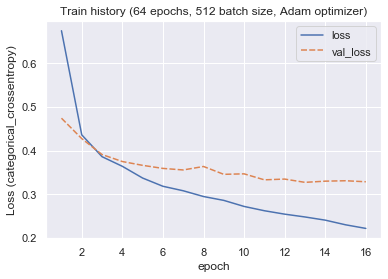

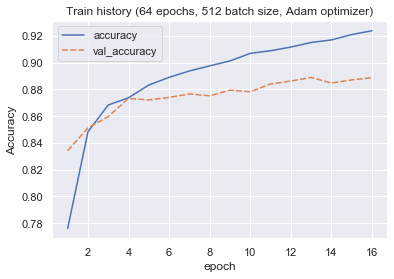

In [32]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val, 
                            n_epochs=64, batch_size=512)

In [33]:
strftime('%X')

'14:39:53'

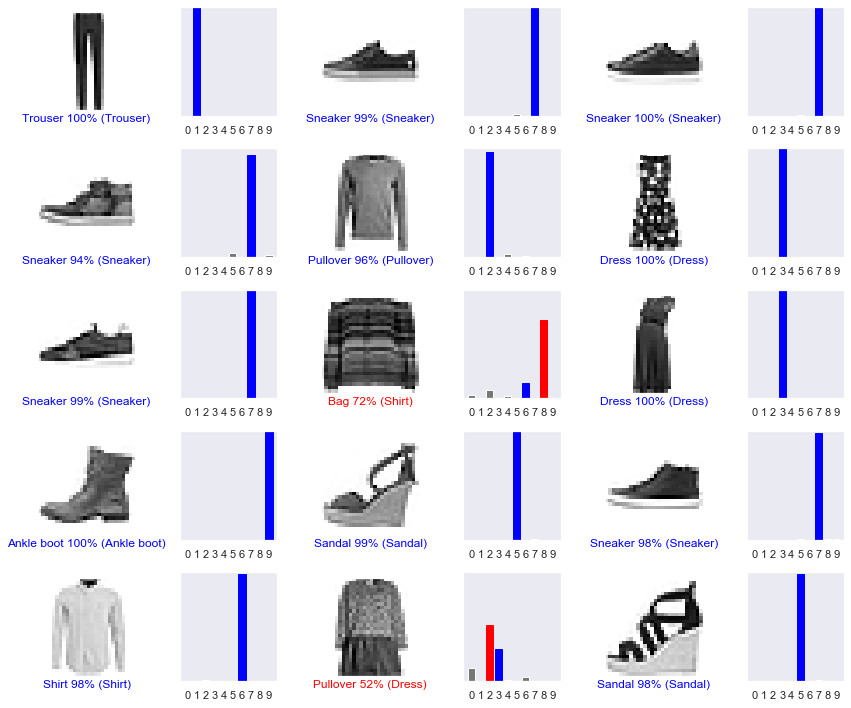

In [34]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

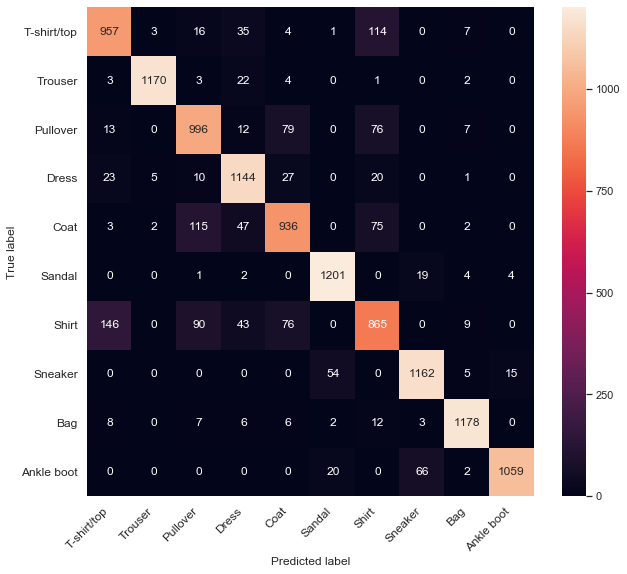

In [35]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

## 1.2. CNN

In [36]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [37]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [38]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [39]:
conv_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [40]:
strftime('%X')

'14:39:57'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 67us/sample - loss: 0.7332 - accuracy: 0.7618 - val_loss: 0.4903 - val_accuracy: 0.8366
Epoch 2/64
48000/48000 [==============================] - 2s 36us/sample - loss: 0.4412 - accuracy: 0.8520 - val_loss: 0.4140 - val_accuracy: 0.8602
Epoch 3/64
48000/48000 [==============================] - 2s 36us/sample - loss: 0.3929 - accuracy: 0.8702 - val_loss: 0.3710 - val_accuracy: 0.8788
Epoch 4/64
48000/48000 [==============================] - 2s 37us/sample - loss: 0.3519 - accuracy: 0.8855 - val_loss: 0.3529 - val_accuracy: 0.8845
Epoch 5/64
48000/48000 [==============================] - 2s 37us/sample - loss: 0.3340 - accuracy: 0.8915 - val_loss: 0.3436 - val_accuracy: 0.8858
Epoch 6/64
48000/48000 [==============================] - 2s 37us/sample - loss: 0.3188 - accuracy: 0.8976 - val_loss: 0.3298 - val_accuracy: 0.8928
Epoch 7/64
48000/48000 [===========

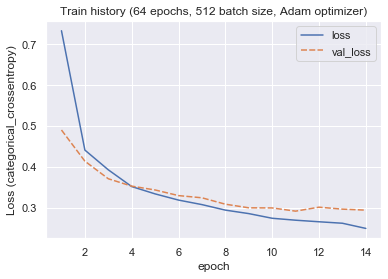

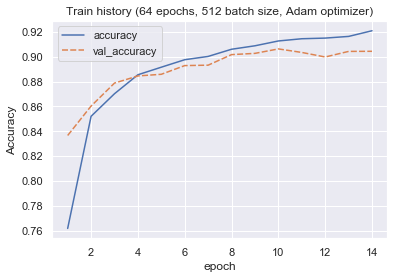

In [41]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val, 
                                      n_epochs=64, batch_size=512)

In [42]:
strftime('%X')

'14:40:24'

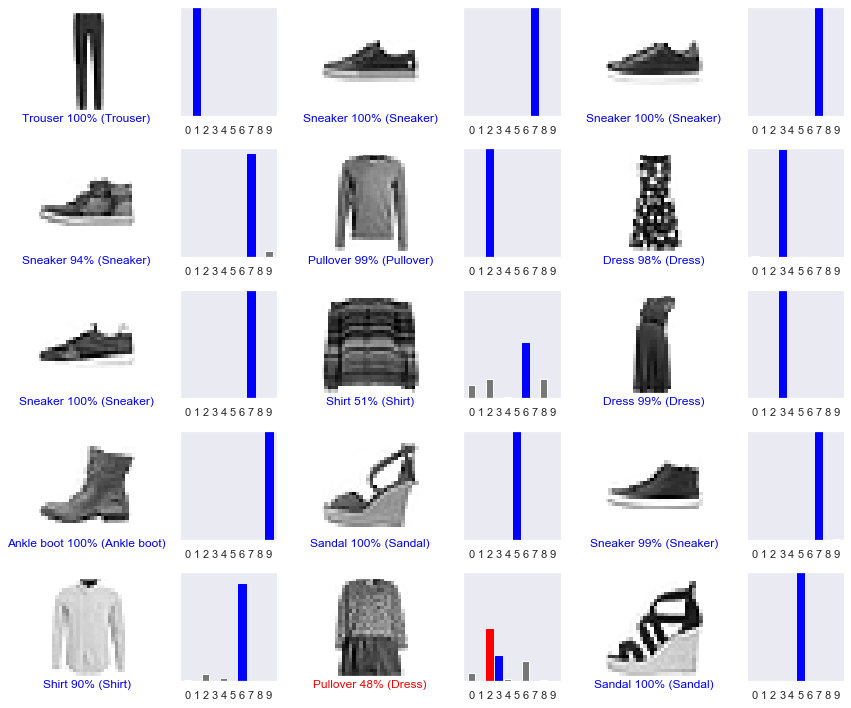

In [43]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

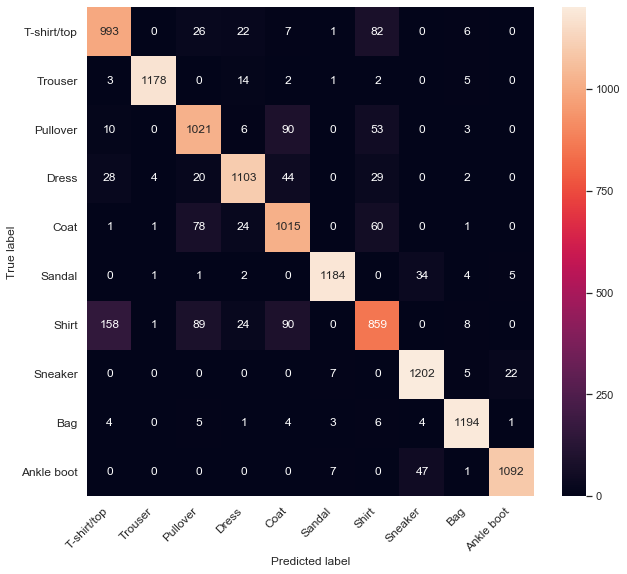

In [44]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 1.3. CNN with batch normalization

In [45]:
from tensorflow.keras.layers import Dropout, BatchNormalization, ReLU

In [46]:
# obs.: padding='valid' by default (i.e. no padding)
conv_v2_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1)),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_v2_baseline")

In [47]:
conv_v2_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [48]:
conv_v2_model.summary()

Model: "CNN_v2_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)    

In [49]:
conv_v2_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [50]:
strftime('%X')

'14:40:28'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 60us/sample - loss: 0.5806 - accuracy: 0.8133 - val_loss: 1.4078 - val_accuracy: 0.5181
Epoch 2/64
48000/48000 [==============================] - 2s 46us/sample - loss: 0.3493 - accuracy: 0.8831 - val_loss: 1.1361 - val_accuracy: 0.5729
Epoch 3/64
48000/48000 [==============================] - 2s 46us/sample - loss: 0.3032 - accuracy: 0.8996 - val_loss: 0.7728 - val_accuracy: 0.7370
Epoch 4/64
48000/48000 [==============================] - 2s 47us/sample - loss: 0.2692 - accuracy: 0.9108 - val_loss: 0.5124 - val_accuracy: 0.8371
Epoch 5/64
48000/48000 [==============================] - 2s 46us/sample - loss: 0.2489 - accuracy: 0.9180 - val_loss: 0.3605 - val_accuracy: 0.8812
Epoch 6/64
48000/48000 [==============================] - 2s 47us/sample - loss: 0.2268 - accuracy: 0.9251 - val_loss: 0.2926 - val_accuracy: 0.9020
Epoch 7/64
48000/48000 [===========

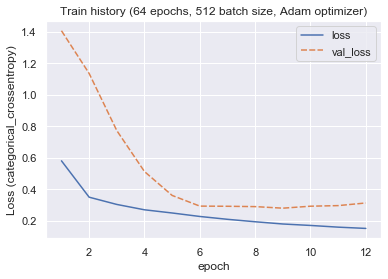

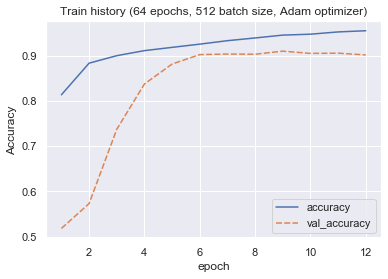

In [51]:
conv_v2_history, best_conv_v2_model = train(conv_v2_model, X_train, Y_train, X_val, Y_val, 
                                            n_epochs=64, batch_size=512)

In [52]:
strftime('%X')

'14:40:56'

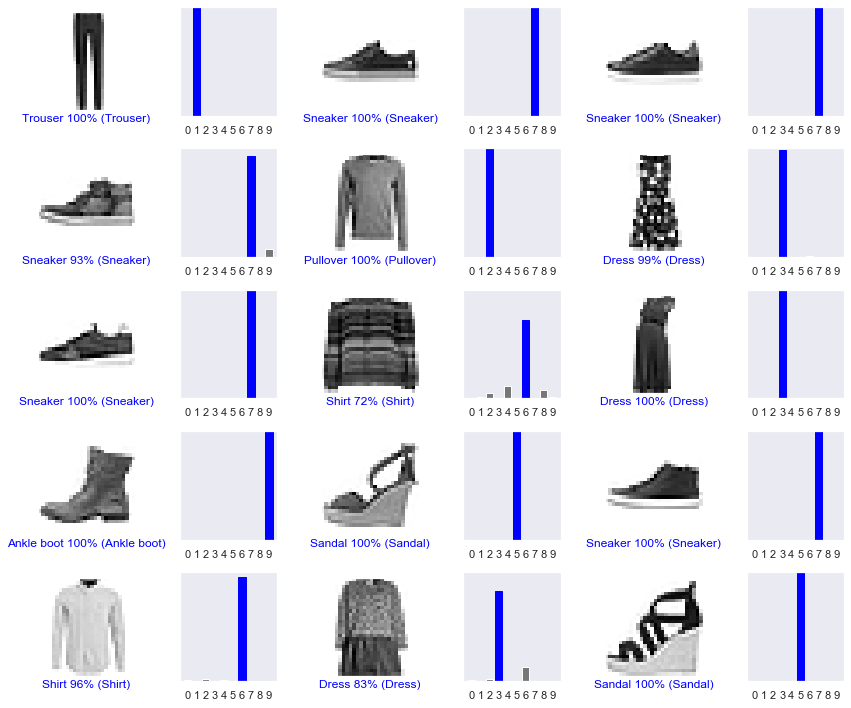

In [53]:
Y_val_conv_v2_pred = best_conv_v2_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_v2_pred)

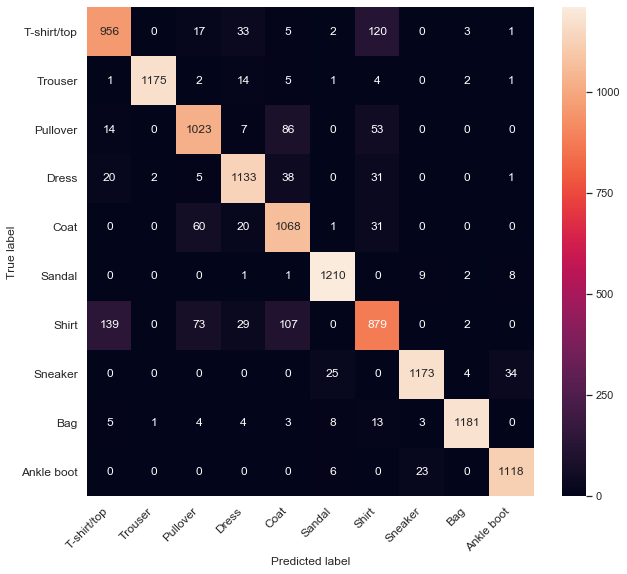

In [54]:
print_cm(ys_val, np.argmax(Y_val_conv_v2_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [55]:
from sklearn.decomposition import PCA

In [56]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [57]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [58]:
def apply_pca(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    print()
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    print(model_pca.summary())
    print()
    
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)
    
    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence
    
    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)
    
    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    

In [59]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [60]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

## 2.1. 99% explained variance

In [61]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491833686829 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 8s 162us/sample - loss: 0.7166 - accuracy: 0.7706 - val_loss: 0.4323 - val_accuracy: 0.8576
Epoch 2/64
48000/48000 [==============================] - 7s 150us/sample - loss: 0.3859 - accuracy: 0.8698 - val_loss: 0.3812 - val_accuracy: 0.8732
Epoch 3/64
48000/48000 [==============================] - 8s 175us/sample - loss: 0.3287 - accuracy: 0.8908 - val_loss: 0.3598 - val_accuracy: 0.8781
Epoch 4/64
48000/48000 [==============================] - 9s 183us/sample - loss: 0.2940 - accuracy: 0.9034 - val_loss: 0.3517 - val_accuracy: 0.8801
Epoch 5/64
48000/48000 [==============================] - 8s 157us/sample - loss: 0.2660 - accuracy: 0.9143 - val_loss: 0.3432 - val_accuracy: 0.8849
Epoch 6/64
48000/48000 [==============================] - 8s 168us/sample - loss: 0.2433 - accuracy: 0.9216 - val_loss: 0.3407 - val_accuracy: 0.8846
Epoch 7/64
48000/48000 [=====

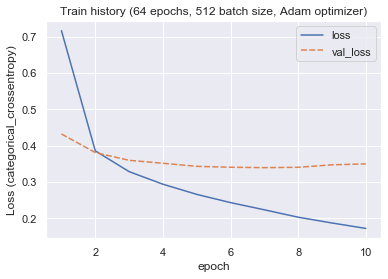

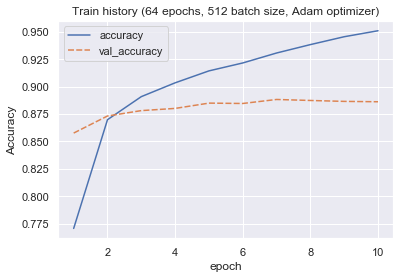

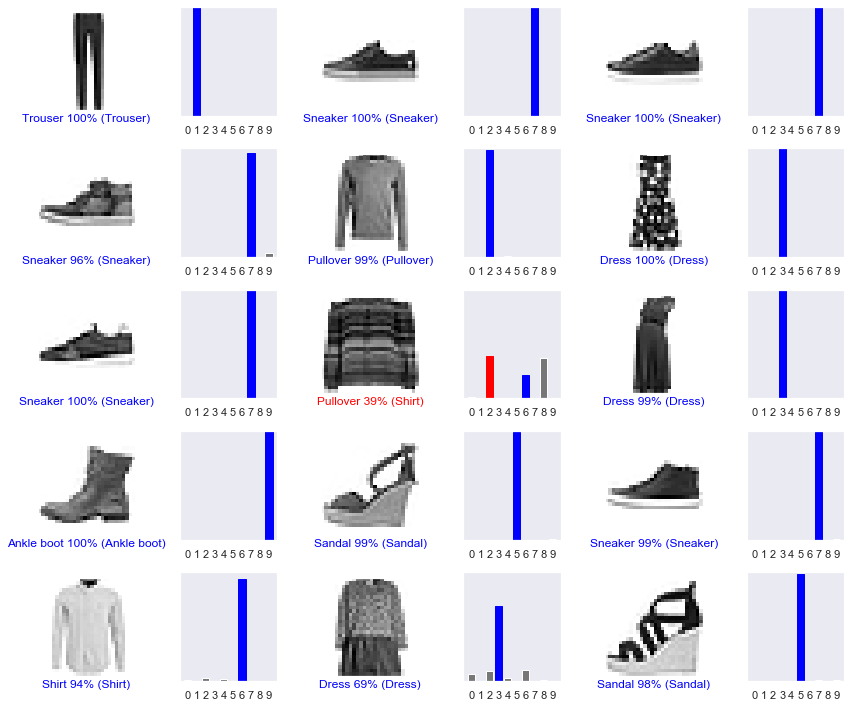

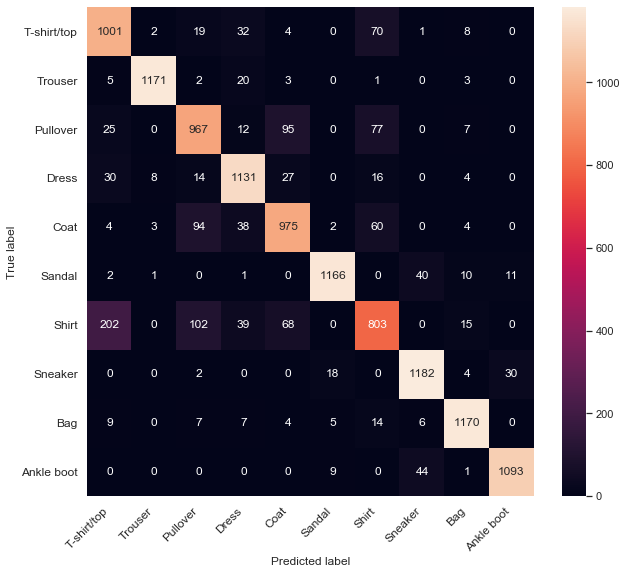

In [62]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

## 2.2. 95% explained variance

In [63]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 7s 144us/sample - loss: 0.8094 - accuracy: 0.7390 - val_loss: 0.4641 - val_accuracy: 0.8425
Epoch 2/64
48000/48000 [==============================] - 7s 137us/sample - loss: 0.4146 - accuracy: 0.8590 - val_loss: 0.4011 - val_accuracy: 0.8627
Epoch 3/64
48000/48000 [==============================] - 7s 150us/sample - loss: 0.3630 - accuracy: 0.8771 - val_loss: 0.3751 - val_accuracy: 0.8700
Epoch 4/64
48000/48000 [==============================] - 6s 122us/sample - loss: 0.3307 - accuracy: 0.8892 - val_loss: 0.3613 - val_accuracy: 0.8752
Epoch 5/64
48000/48000 [==============================] - 6s 129us/sample - loss: 0.3077 - accuracy: 0.8972 - val_loss: 0.3445 - val_accuracy: 0.8813
Epoch 6/64
48000/48000 [==============================] - 6s 118us/sample - loss: 0.2882 - accuracy: 0.9044 - val_loss: 0.3399 - val_accuracy: 0.8865
Epoch 7/64
48000/48000 [=====

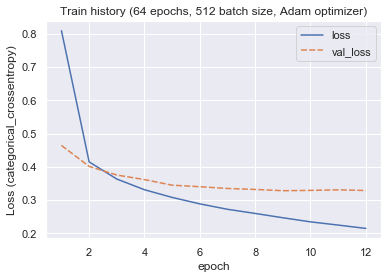

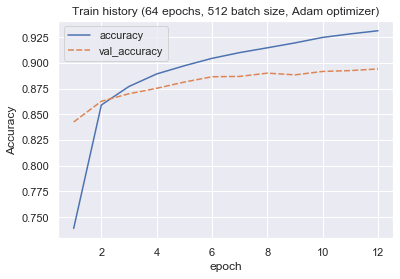

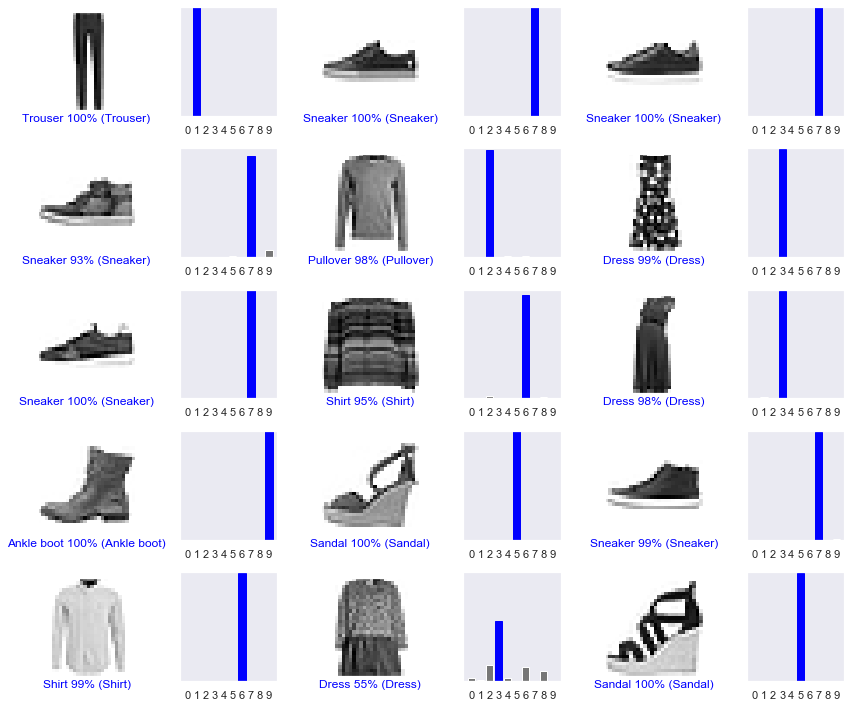

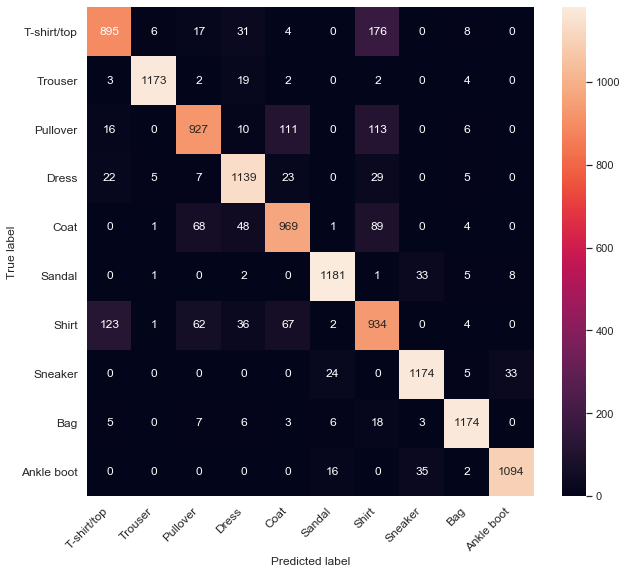

In [64]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

## 2.3. 90% explained variance

In [65]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006991386413574 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 118us/sample - loss: 0.8719 - accuracy: 0.7180 - val_loss: 0.4915 - val_accuracy: 0.8347
Epoch 2/64
48000/48000 [==============================] - 5s 105us/sample - loss: 0.4484 - accuracy: 0.8486 - val_loss: 0.4221 - val_accuracy: 0.8583
Epoch 3/64
48000/48000 [==============================] - 5s 113us/sample - loss: 0.3965 - accuracy: 0.8653 - val_loss: 0.3990 - val_accuracy: 0.8652
Epoch 4/64
48000/48000 [==============================] - 5s 104us/sample - loss: 0.3688 - accuracy: 0.8745 - val_loss: 0.3794 - val_accuracy: 0.8679
Epoch 5/64
48000/48000 [==============================] - 5s 105us/sample - loss: 0.3492 - accuracy: 0.8818 - val_loss: 0.3657 - val_accuracy: 0.8746
Epoch 6/64
48000/48000 [==============================] - 6s 130us/sample - loss: 0.3340 - accuracy: 0.8867 - val_loss: 0.3582 - val_accuracy: 0.8758
Epoch 7/64
48000/48000 [=====

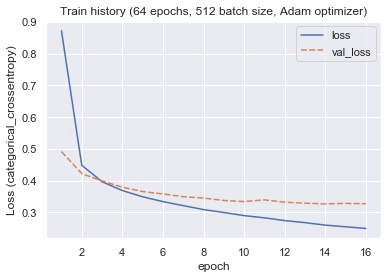

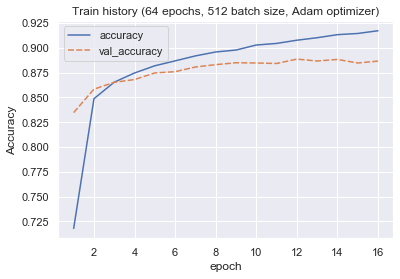

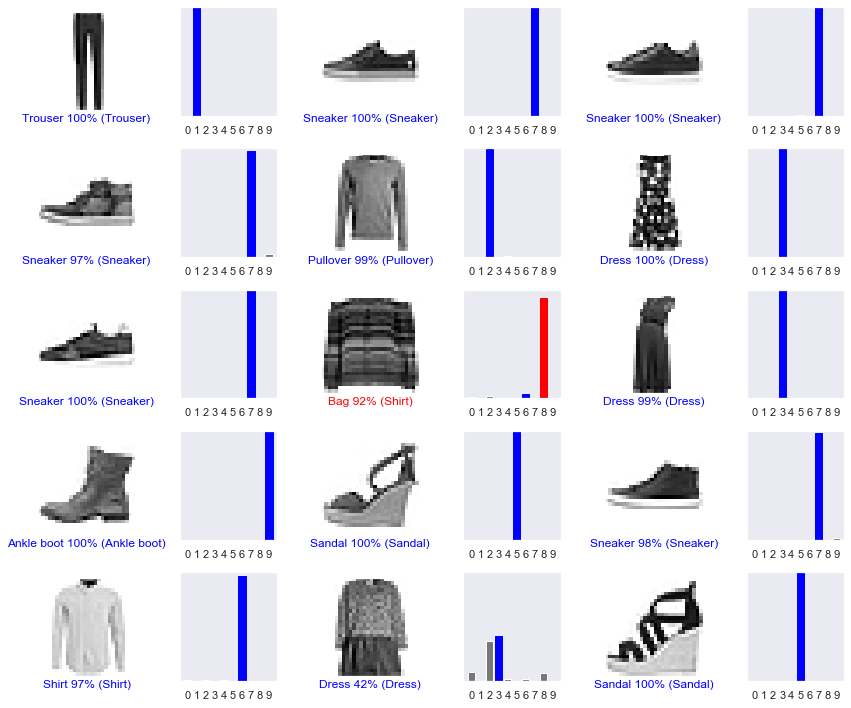

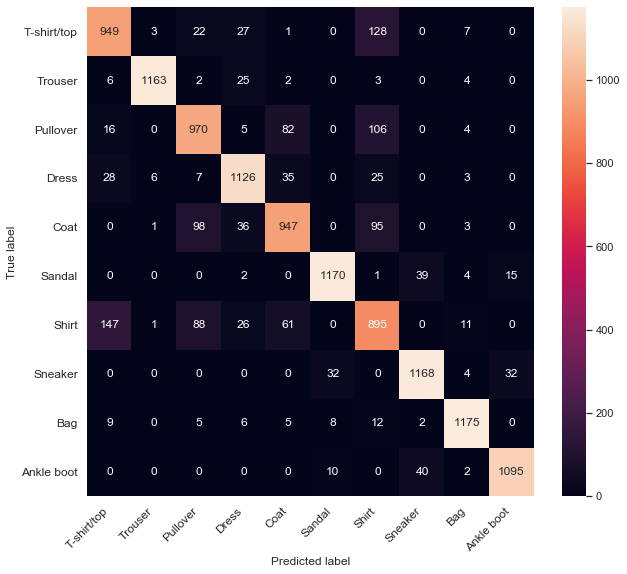

In [66]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

## 2.4. F1-scores

In [91]:
from sklearn.metrics import precision_recall_fscore_support

In [128]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [129]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8300  |  0.8417  |  0.8358
Class 1 (Trouser):       0.9915  |  0.9710  |  0.9811
Class 2 (Pullover):      0.8045  |  0.8419  |  0.8228
Class 3 (Dress):         0.8726  |  0.9301  |  0.9004
Class 4 (Coat):          0.8269  |  0.7932  |  0.8097
Class 5 (Sandal):        0.9397  |  0.9756  |  0.9574
Class 6 (Shirt):         0.7438  |  0.7038  |  0.7232
Class 7 (Sneaker):       0.9296  |  0.9401  |  0.9348
Class 8 (Bag):           0.9680  |  0.9640  |  0.9660
Class 9 (Ankle boot):    0.9824  |  0.9233  |  0.9519

Combined F1 score:  0.8803
Combined Precision: 0.8813
Combined Recall:    0.8794


In [130]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8296  |  0.8734  |  0.8509
Class 1 (Trouser):       0.9941  |  0.9776  |  0.9858
Class 2 (Pullover):      0.8234  |  0.8631  |  0.8428
Class 3 (Dress):         0.9222  |  0.8967  |  0.9093
Class 4 (Coat):          0.8107  |  0.8602  |  0.8347
Class 5 (Sandal):        0.9842  |  0.9618  |  0.9729
Class 6 (Shirt):         0.7874  |  0.6989  |  0.7405
Class 7 (Sneaker):       0.9340  |  0.9725  |  0.9528
Class 8 (Bag):           0.9715  |  0.9771  |  0.9743
Class 9 (Ankle boot):    0.9750  |  0.9520  |  0.9634

Combined F1 score:  0.8956
Combined Precision: 0.8964
Combined Recall:    0.8947


In [131]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7833  |  0.8804  |  0.8290
Class 1 (Trouser):       0.9882  |  0.9718  |  0.9799
Class 2 (Pullover):      0.8012  |  0.8174  |  0.8092
Class 3 (Dress):         0.8836  |  0.9195  |  0.9012
Class 4 (Coat):          0.8291  |  0.8263  |  0.8277
Class 5 (Sandal):        0.9717  |  0.9472  |  0.9593
Class 6 (Shirt):         0.7714  |  0.6534  |  0.7075
Class 7 (Sneaker):       0.9285  |  0.9563  |  0.9422
Class 8 (Bag):           0.9543  |  0.9574  |  0.9559
Class 9 (Ankle boot):    0.9638  |  0.9529  |  0.9584

Combined F1 score:  0.8782
Combined Precision: 0.8801
Combined Recall:    0.8763


In [132]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8412  |  0.7872  |  0.8133
Class 1 (Trouser):       0.9882  |  0.9734  |  0.9808
Class 2 (Pullover):      0.8505  |  0.7836  |  0.8157
Class 3 (Dress):         0.8823  |  0.9260  |  0.9036
Class 4 (Coat):          0.8219  |  0.8212  |  0.8215
Class 5 (Sandal):        0.9602  |  0.9594  |  0.9598
Class 6 (Shirt):         0.6858  |  0.7600  |  0.7210
Class 7 (Sneaker):       0.9430  |  0.9498  |  0.9464
Class 8 (Bag):           0.9647  |  0.9607  |  0.9627
Class 9 (Ankle boot):    0.9639  |  0.9538  |  0.9588

Combined F1 score:  0.8798
Combined Precision: 0.8802
Combined Recall:    0.8794


In [133]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8216  |  0.8347  |  0.8281
Class 1 (Trouser):       0.9906  |  0.9651  |  0.9777
Class 2 (Pullover):      0.8138  |  0.8199  |  0.8168
Class 3 (Dress):         0.8986  |  0.9154  |  0.9070
Class 4 (Coat):          0.8358  |  0.8025  |  0.8188
Class 5 (Sandal):        0.9590  |  0.9504  |  0.9547
Class 6 (Shirt):         0.7075  |  0.7282  |  0.7177
Class 7 (Sneaker):       0.9351  |  0.9450  |  0.9400
Class 8 (Bag):           0.9655  |  0.9615  |  0.9635
Class 9 (Ankle boot):    0.9588  |  0.9547  |  0.9567

Combined F1 score:  0.8798
Combined Precision: 0.8796
Combined Recall:    0.8800


## 2.4. <90% explained variance

In [138]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008706569671631 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 5s 105us/sample - loss: 0.8639 - accuracy: 0.7132 - val_loss: 0.5480 - val_accuracy: 0.8136
Epoch 2/64
48000/48000 [==============================] - 4s 93us/sample - loss: 0.5032 - accuracy: 0.8259 - val_loss: 0.4780 - val_accuracy: 0.8358
Epoch 3/64
48000/48000 [==============================] - 4s 92us/sample - loss: 0.4533 - accuracy: 0.8427 - val_loss: 0.4453 - val_accuracy: 0.8462
Epoch 4/64
48000/48000 [==============================] - 5s 96us/sample - loss: 0.4277 - accuracy: 0.8509 - val_loss: 0.4283 - val_accuracy: 0.8512
Epoch 5/64
48000/48000 [==============================] - 5s 96us/sample - loss: 0.4095 - accuracy: 0.8585 - val_loss: 0.4179 - val_accuracy: 0.8562
Epoch 6/64
48000/48000 [==============================] - 6s 118us/sample - loss: 0.3975 - accuracy: 0.8625 - val_loss: 0.4112 - val_accuracy: 0.8568
Epoch 7/64
48000/48000 [=========

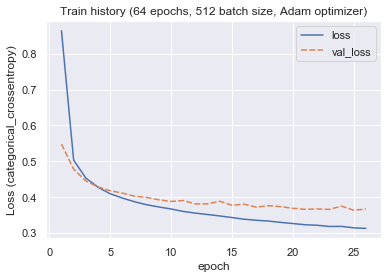

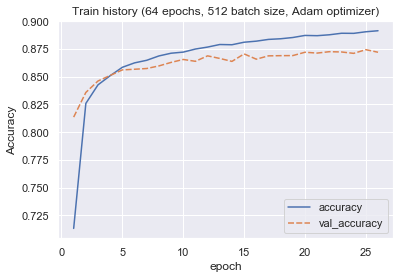

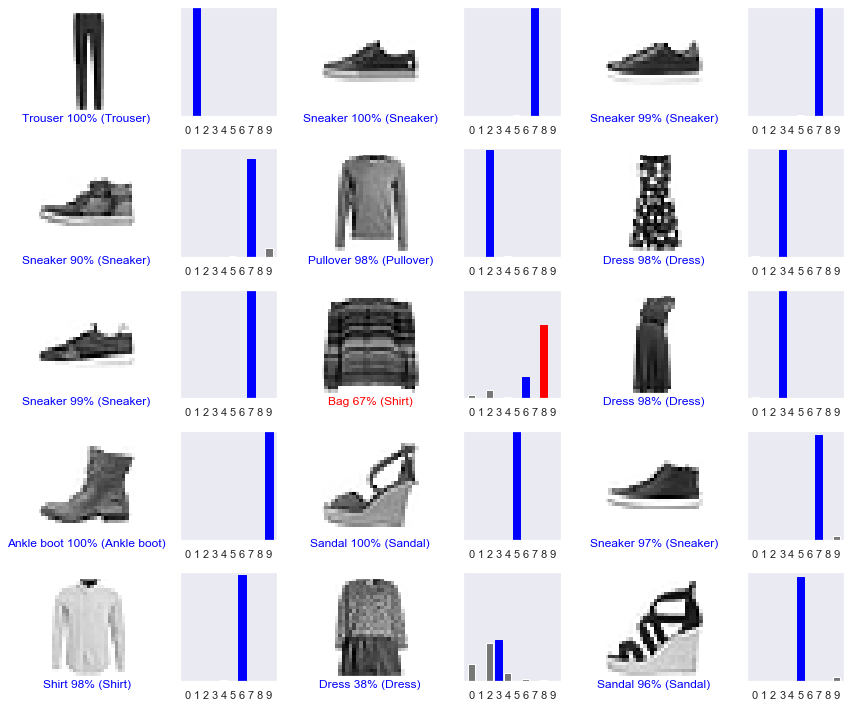

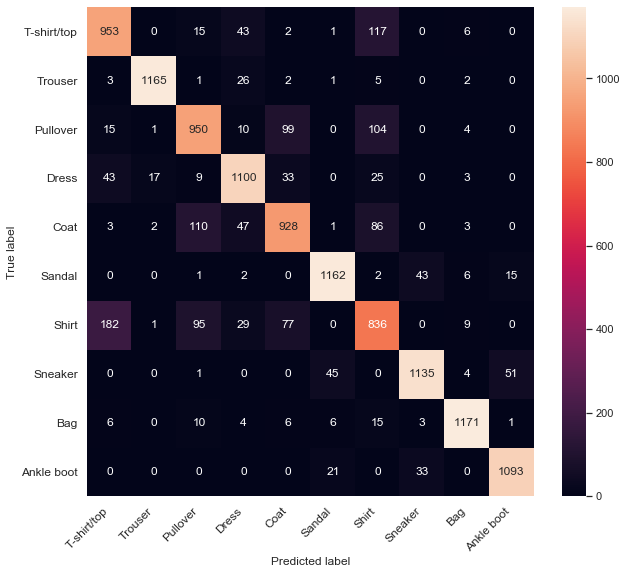

In [139]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [142]:
# 80% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7909  |  0.8382  |  0.8138
Class 1 (Trouser):       0.9823  |  0.9668  |  0.9745
Class 2 (Pullover):      0.7970  |  0.8030  |  0.8000
Class 3 (Dress):         0.8723  |  0.8943  |  0.8832
Class 4 (Coat):          0.8091  |  0.7864  |  0.7976
Class 5 (Sandal):        0.9394  |  0.9439  |  0.9417
Class 6 (Shirt):         0.7025  |  0.6802  |  0.6912
Class 7 (Sneaker):       0.9349  |  0.9183  |  0.9265
Class 8 (Bag):           0.9694  |  0.9583  |  0.9638
Class 9 (Ankle boot):    0.9422  |  0.9529  |  0.9476

Combined F1 score:  0.8642
Combined Precision: 0.8643
Combined Recall:    0.8640


In [143]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156877279281616 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 4s 93us/sample - loss: 1.1068 - accuracy: 0.6137 - val_loss: 0.8026 - val_accuracy: 0.7088
Epoch 2/64
48000/48000 [==============================] - 5s 94us/sample - loss: 0.7667 - accuracy: 0.7134 - val_loss: 0.7457 - val_accuracy: 0.7172
Epoch 3/64
48000/48000 [==============================] - 4s 79us/sample - loss: 0.7293 - accuracy: 0.7260 - val_loss: 0.7145 - val_accuracy: 0.7281
Epoch 4/64
48000/48000 [==============================] - 3s 71us/sample - loss: 0.7111 - accuracy: 0.7316 - val_loss: 0.7060 - val_accuracy: 0.7283
Epoch 5/64
48000/48000 [==============================] - 5s 95us/sample - loss: 0.6998 - accuracy: 0.7344 - val_loss: 0.6996 - val_accuracy: 0.7352
Epoch 6/64
48000/48000 [==============================] - 5s 111us/sample - loss: 0.6911 - accuracy: 0.7369 - val_loss: 0.6918 - val_accuracy: 0.7373
Epoch 7/64
48000/48000 [==========

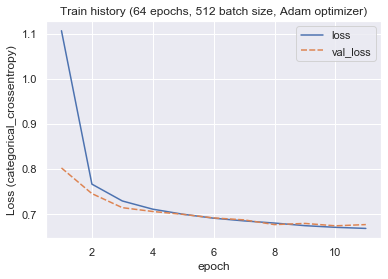

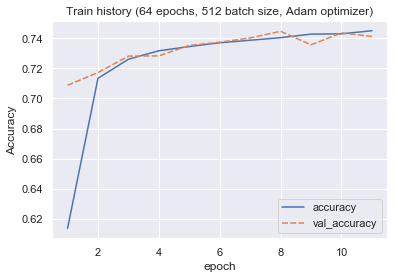

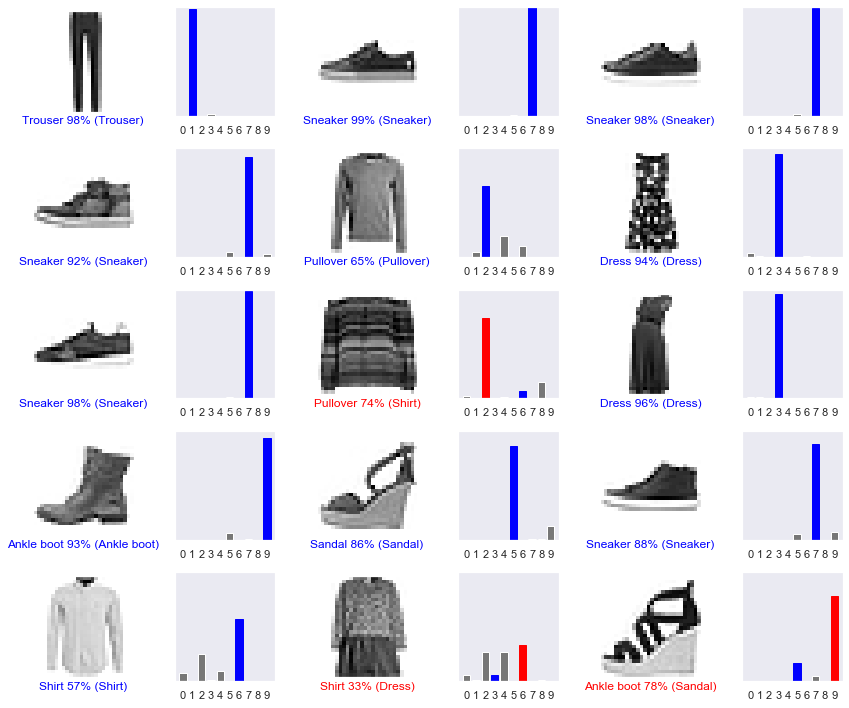

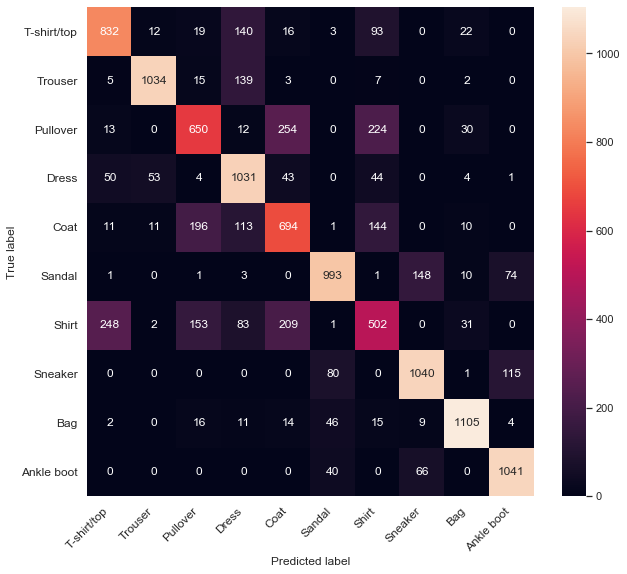

In [144]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [145]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7160  |  0.7318  |  0.7238
Class 1 (Trouser):       0.9299  |  0.8581  |  0.8925
Class 2 (Pullover):      0.6167  |  0.5495  |  0.5811
Class 3 (Dress):         0.6730  |  0.8382  |  0.7466
Class 4 (Coat):          0.5629  |  0.5881  |  0.5752
Class 5 (Sandal):        0.8531  |  0.8067  |  0.8292
Class 6 (Shirt):         0.4874  |  0.4085  |  0.4444
Class 7 (Sneaker):       0.8234  |  0.8414  |  0.8323
Class 8 (Bag):           0.9095  |  0.9043  |  0.9069
Class 9 (Ankle boot):    0.8429  |  0.9076  |  0.8741

Combined F1 score:  0.7040
Combined Precision: 0.7102
Combined Recall:    0.6979


## 2.5. Plot the first 3 principal components

In [73]:
pca_3pc = PCA(n_components=3)

In [74]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [75]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


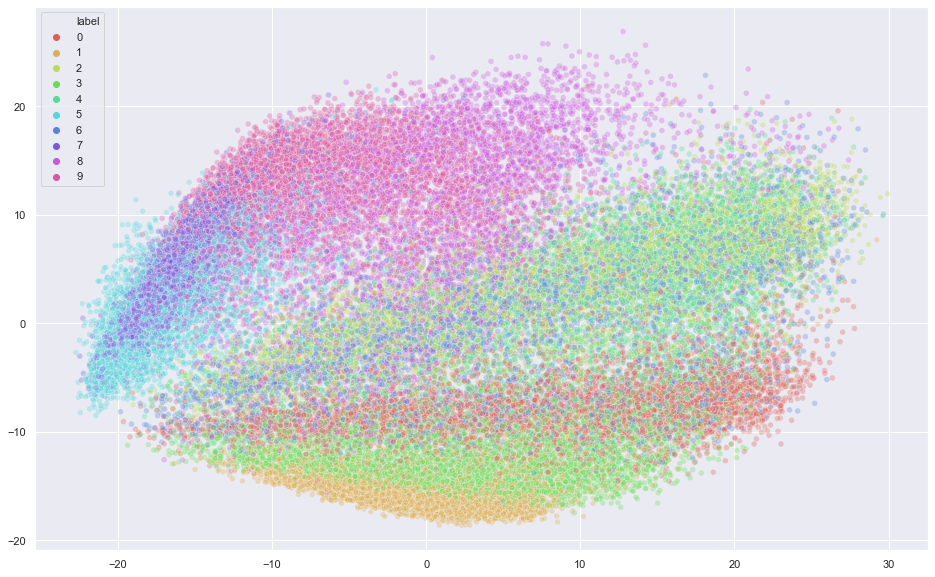

In [76]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [77]:
from mpl_toolkits.mplot3d import Axes3D

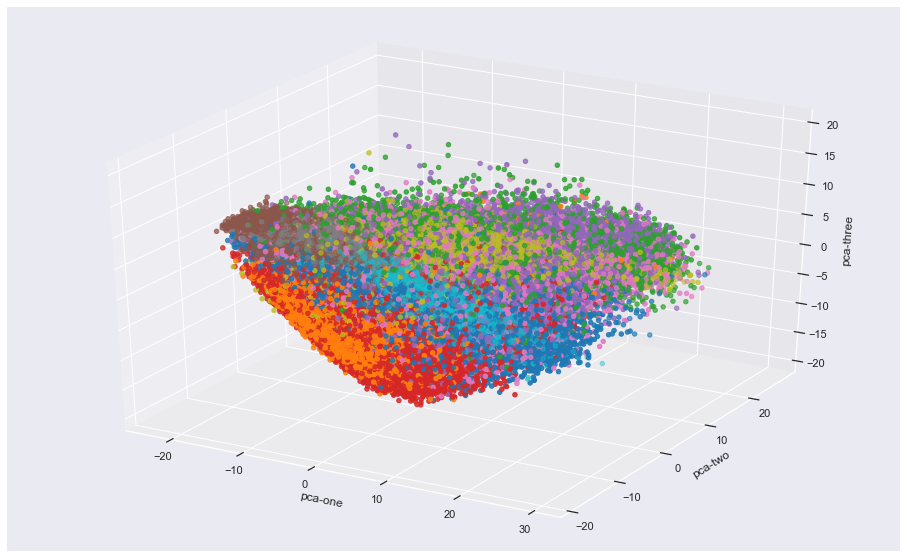

In [78]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 2.6. 100% variance explained

In [79]:
# TODO only apply PCA but don't reduce dimensionality (this way we can test the CNN model aswell)

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.